# Create Tables and Figures
Author: Mark Bauer

In [1]:
# import libraries
from datetime import datetime
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cpi

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,pandas,matplotlib,seaborn,cpi

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
pandas    : 1.5.1
matplotlib: 3.6.2
seaborn   : 0.12.1
cpi       : 2.0.3



In [3]:
current_date = datetime.now()
print(f"This notebook was executed on {current_date.strftime('%Y-%m-%d')}.")

This notebook was executed on 2025-04-02.


# Getting Started: OpenFEMA
- [OpenFEMA](https://www.fema.gov/about/reports-and-data/openfema): The public’s resource for FEMA program data. Promoting a culture of Open Government and increasing transparency, participation, and collaboration among the Whole Community in support of FEMA's mission to help people before, during, and after disasters.


- [OpenFEMA Developer Resources](https://www.fema.gov/about/openfema/developer-resources): Welcome to the OpenFEMA Developer Resources page, devoted to providing additional development information regarding our Application Programming Interface (API) for use in your applications and mashups.  The API is free of charge and does not currently have user registration requirements.


- [OpenFEMA API Documentation](https://www.fema.gov/about/openfema/api): As part of the OpenFEMA initiative, FEMA is providing read-only API based access to datasets (Entities). The data is exposed using a RESTful interface that uses query string parameters to manage the query. Use of the service is free and does not require a subscription or API key.


- [OpenFEMA Terms and Conditions](https://www.fema.gov/about/openfema/terms-conditions): Respect the OpenFEMA API and content on this website. Use the Site in a lawful manner. Do not modify the Site or attempt to use it to publish or transmit malicious software or content. FEMA shall not be liable for any damages resulting from the use of this website, API services, or content. Do not attempt to reidentify the individuals whose data may be aggregated. We may suspend your access to this website if we feel you have not complied with these terms and conditions..

# OpenFEMA Dataset: FIMA NFIP Redacted Claims - v2

[OpenFEMA Dataset: FIMA NFIP Redacted Policies - v2](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v2): Congress passed the National Flood Insurance Act (NFIA), 42 U.S.C. 4001 in 1968, creating the National Flood Insurance Program (NFIP) in order to reduce future flood losses through flood hazard identification, floodplain management, and providing insurance protection. This dataset provides details on NFIP policy transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information.

# OpenFEMA Dataset: FIMA NFIP Redacted Policies - v2

[OpenFEMA Dataset: FIMA NFIP Redacted Policies - v2](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v2): Congress passed the National Flood Insurance Act (NFIA), 42 U.S.C. 4001 in 1968, creating the National Flood Insurance Program (NFIP) in order to reduce future flood losses through flood hazard identification, floodplain management, and providing insurance protection. This dataset provides details on NFIP policy transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information.

# Read Data in DuckDB

In [4]:
# create a DuckDB database instance
con = duckdb.connect()

# create the 'claims' table from Parquet file
con.execute("""
    CREATE TABLE claims AS
    SELECT *
    FROM read_parquet('data/nfip-claims-nyc.parquet')
""")

# create the 'policies' table from Parquet file
con.execute("""
    CREATE TABLE policies AS
    SELECT *
    FROM read_parquet('data/nfip-policies-nyc.parquet')
""")

# create the '311 street flooding complaints' table from Parquet file
con.execute("""
    CREATE TABLE complaints AS
    SELECT *
    FROM read_csv('data/complaints.csv')
""")

# show tables
con.execute("SHOW TABLES").fetchall()

[('claims',), ('complaints',), ('policies',)]

In [5]:
# sanity check, count claims
sql = """
    SELECT COUNT(*) AS count
    FROM claims
"""

con.sql(sql)

┌───────┐
│ count │
│ int64 │
├───────┤
│ 43978 │
└───────┘

In [6]:
# sanity check, count policies
sql = """
    SELECT COUNT(*) AS count
    FROM policies
"""

con.sql(sql)

┌────────┐
│ count  │
│ int64  │
├────────┤
│ 548267 │
└────────┘

In [7]:
# sanity check, count policies
sql = """
    SELECT COUNT(*) AS count
    FROM complaints
"""

con.sql(sql)

┌───────┐
│ count │
│ int64 │
├───────┤
│ 41623 │
└───────┘

# Preview Data

In [8]:
# sanity check, claims preview
sql = """
    SELECT *
    FROM claims
    LIMIT 5
"""

con.sql(sql).df()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,...,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,2020-09-10T19:02:52.738Z,1.0,1,NaN,2012-10-29T00:00:00.000Z,False,None,NaN,NaN,...,False,NY,Currently Unavailable,10465,36005,36005013800,360050138001,40.8,-73.8,80349555-9429-4ec2-853b-b43d08964ef4
1,False,2024-09-23T14:02:07.503Z,1.0,1,NaN,2012-10-29T00:00:00.000Z,False,None,NaN,NaN,...,False,NY,Currently Unavailable,10464,36005,36005051601,360050516011,40.9,-73.8,e1d4d5a4-c438-4ef1-9425-37c192425e56
2,False,2020-01-22T16:55:53.194Z,2.0,1,NaN,2012-10-28T00:00:00.000Z,False,1,NaN,NaN,...,False,NY,Currently Unavailable,10473,36005,36005000400,360050004003,40.8,-73.9,c9b02a95-815a-4c69-814a-fc9652fe0a5d
3,False,2020-01-22T16:55:53.194Z,2.0,1,NaN,2011-08-28T00:00:00.000Z,False,1,NaN,NaN,...,False,NY,Currently Unavailable,10473,36005,36005000400,360050004003,40.8,-73.9,c43c75c0-9add-4c96-8169-7b97487db865
4,False,2020-01-22T16:55:53.194Z,NaN,1,NaN,2011-08-28T00:00:00.000Z,False,1,NaN,NaN,...,False,NY,Currently Unavailable,10465,36005,36005013200,360050132001,40.8,-73.8,4fd50779-17b7-4461-84a5-bda82bcc7ffd


In [9]:
# sanity check, policies preview
sql = """
    SELECT *
    FROM policies
    LIMIT 5
"""

con.sql(sql).df()

,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,femaRegion,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,13.0,0.0,None,N,False,NaN,0,0,False,...,2,NY,Currently Unavailable,10473,36005,36005000400,360050004004,40.8,-73.8,c4b3dc22-1f60-4d08-bf2e-11b7b2b18432
1,False,NaN,NaN,None,N,False,NaN,0,0,False,...,2,NY,Currently Unavailable,10475,36005,36005030200,360050302003,40.9,-73.8,e4f4f206-5a14-46e9-803d-767bea2c4b94
2,False,NaN,1.0,None,N,False,NaN,5,5,False,...,2,NY,Currently Unavailable,10474,36005,36005009300,360050093001,40.8,-73.9,93f58e3e-f563-4587-bdd0-a761db3a1080
3,False,NaN,2.0,None,N,False,NaN,None,0,False,...,2,NY,Currently Unavailable,10462,36005,36005009200,360050092002,40.8,-73.8,d4a416b2-f4ad-4cfb-9760-a8271ddd5109
4,False,NaN,1.0,None,N,False,NaN,None,0,False,...,2,NY,Currently Unavailable,10465,36005,36005016000,360050160002,40.8,-73.8,1eda7965-e3ae-4caa-ba27-525e97668929


In [10]:
# sanity check, 311 street flooding complaints preview
sql = """
    SELECT *
    FROM complaints
    LIMIT 5
"""

con.sql(sql).df()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,latitude,longitude,location,closed_date,intersection_street_1,intersection_street_2,facility_type,resolution_description,resolution_action_updated_date,due_date
0,60700670,2024-03-27 16:32:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11236.0,1381 EAST 105 STREET,EAST 105 STREET,FLATLANDS 8 ST,...,40.63964,-73.88588,"{'latitude': '40.63963974342525', 'longitude':...",NaT,None,None,None,None,NaT,NaT
1,18265181,2010-07-14 08:38:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,None,None,PELHAM PKWY,...,NaN,NaN,None,2010-07-14 08:38:00,PELHAM PKWY,STILLWELL AVE,N/A,The Department of Environmental Protection inv...,2010-07-14 08:30:00,NaT
2,21549616,2011-09-29 10:34:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,None,None,None,...,NaN,NaN,None,2011-09-30 10:40:00,THURSBY AVE,GOVENER AVE,N/A,The Department of Environmental Protection inv...,2011-09-30 10:40:00,NaT
3,35839080,2017-03-31 20:24:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10029.0,EAST 106 STREET,EAST 106 STREET,3 AVENUE,...,NaN,NaN,None,2017-04-01 02:25:00,None,None,N/A,Please call 311 for further information. If yo...,2017-04-01 02:25:00,NaT
4,29443390,2014-12-06 10:23:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),NaN,None,None,NAGLE AVE,...,NaN,NaN,None,2014-12-06 11:30:00,NAGLE AVE,DYCKMAN ST,N/A,The Department of Environmental Protection inv...,2014-12-06 11:30:00,NaT


# Explore NFIP Claims Dataset

In [11]:
# column name and data type
sql = """
    SELECT
        column_name,
        column_type
    FROM
        (DESCRIBE claims)
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────────┬─────────────┐
│                column_name                 │ column_type │
│                  varchar                   │   varchar   │
├────────────────────────────────────────────┼─────────────┤
│ agricultureStructureIndicator              │ BOOLEAN     │
│ asOfDate                                   │ VARCHAR     │
│ basementEnclosureCrawlspaceType            │ BIGINT      │
│ policyCount                                │ BIGINT      │
│ crsClassificationCode                      │ BIGINT      │
│ dateOfLoss                                 │ VARCHAR     │
│ elevatedBuildingIndicator                  │ BOOLEAN     │
│ elevationCertificateIndicator              │ VARCHAR     │
│ elevationDifference                        │ BIGINT      │
│ baseFloodElevation                         │ DOUBLE      │
│ ratedFloodZone                             │ VARCHAR     │
│ houseWorship                               │ BOOLEAN     │
│ locationOfContents    

In [12]:
# data type counts
sql = """
    SELECT
        column_type,
        COUNT(*) AS count
    FROM
        (DESCRIBE claims)
    GROUP BY
        column_type
"""

con.sql(sql).show(max_rows=80)

┌─────────────┬───────┐
│ column_type │ count │
│   varchar   │ int64 │
├─────────────┼───────┤
│ BIGINT      │    25 │
│ BOOLEAN     │    10 │
│ VARCHAR     │    26 │
│ DOUBLE      │    11 │
│ UUID        │     1 │
└─────────────┴───────┘



In [13]:
# percent null
sql = """
    SELECT
        column_name,
        null_percentage
    FROM
        (SUMMARIZE FROM claims)
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────────┬─────────────────┐
│                column_name                 │ null_percentage │
│                  varchar                   │  decimal(9,2)   │
├────────────────────────────────────────────┼─────────────────┤
│ crsClassificationCode                      │          100.00 │
│ floodCharacteristicsIndicator              │           99.70 │
│ eventDesignationNumber                     │           97.31 │
│ lowestAdjacentGrade                        │           87.20 │
│ lowestFloorElevation                       │           86.93 │
│ baseFloodElevation                         │           86.62 │
│ elevationDifference                        │           86.50 │
│ nonPaymentReasonBuilding                   │           80.12 │
│ nonPaymentReasonContents                   │           74.26 │
│ nfipCommunityNumberCurrent                 │           73.34 │
│ floodZoneCurrent                           │           73.34 │
│ nfipCommunityName      

# NFIP Claims Data Cleaning
Replace construction date before 1652 as null. Oldest buildings in NYC: https://en.wikipedia.org/wiki/List_of_the_oldest_buildings_in_New_York

In [14]:
sql = """
    WITH date_columns AS (
        SELECT
            dateOfLoss,
            originalConstructionDate,
            originalNBDate
        FROM
            claims
    )  
    SELECT column_name, min, max FROM (SUMMARIZE date_columns)
"""

con.sql(sql).to_df()

,column_name,min,max
0,dateOfLoss,1978-01-01T00:00:00.000Z,2025-03-02T00:00:00.000Z
1,originalConstructionDate,1492-10-12T00:00:00.000Z,2022-06-24T00:00:00.000Z
2,originalNBDate,1975-09-06T00:00:00.000Z,2024-09-25T00:00:00.000Z


In [15]:
# update values
sql = """
    UPDATE claims
        SET
            originalConstructionDate = NULL
        WHERE
            strftime('%Y', CAST(originalConstructionDate AS TIMESTAMP)) < '1652'
"""

con.sql(sql)

# format date columns
sql = """
    UPDATE claims
        SET
            dateOfLoss = strftime('%Y-%m-%d', CAST(dateOfLoss AS TIMESTAMP)),
            originalConstructionDate = strftime('%Y-%m-%d', CAST(originalConstructionDate AS TIMESTAMP)),
            originalNBDate = strftime('%Y-%m-%d', CAST(originalNBDate AS TIMESTAMP))
"""
con.sql(sql)

In [16]:
# sanity check
sql = """
    WITH date_columns AS (
        SELECT
            dateOfLoss,
            originalConstructionDate,
            originalNBDate
        FROM
            claims
    )  
    SELECT column_name, min, max FROM (SUMMARIZE date_columns)
"""

con.sql(sql).to_df()

,column_name,min,max
0,dateOfLoss,1978-01-01,2025-03-02
1,originalConstructionDate,1860-05-01,2022-06-24
2,originalNBDate,1975-09-06,2024-09-25


# Create Tables and Figures
Note: column `total_amount_paidM` is in millions.

In [17]:
# table of key statistics
sql = """
    SELECT
        COUNT(*) AS count,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000, 3) AS total_amount_paidM,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::BIGINT AS average_amount_paid 
    FROM
        claims
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(1, 3)


,count,total_amount_paidM,average_amount_paid
0,43978,1463.057,33268


# Examine Claims by County

NYC County FIPS codes:  
- The Bronx is Bronx County (FIPS 36005)  
- Brooklyn is Kings County (FIPS 36047)  
- Manhattan is New York County (FIPS 36061)  
- Queens is Queens County (FIPS 36081)  
- Staten Island is Richmond County (FIPS 36085)

In [18]:
sql = """
    SELECT
        CASE
            WHEN countyCode = 36005 THEN 'BX'
            WHEN countyCode = 36047 THEN 'BK'
            WHEN countyCode = 36061 THEN 'MN'
            WHEN countyCode = 36081 THEN 'QN'
            WHEN countyCode = 36085 THEN 'SI'
            END as county,                                                     
        COUNT(*) AS count,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000, 3) AS total_amount_paidM,
        ROUND((SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_amount_paid 
    FROM
        claims
    GROUP BY
        county
    ORDER BY
        total_amount_paidM DESC 
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(5, 4)


,county,count,total_amount_paidM,average_amount_paid
0,QN,14873,704.901,47395
1,BK,6264,328.603,52459
2,SI,19414,281.761,14513
3,MN,1485,120.391,81071
4,BX,1942,27.401,14110


In [19]:
sql = """
    SELECT
        floodEvent,
        yearOfLoss,
        COUNT(*) AS count,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000, 3) AS total_amount_paidM,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::BIGINT AS average_amount_paid 
    FROM
        claims
    WHERE
        floodEvent NOT NULL
    GROUP BY
        floodEvent, yearOfLoss
    ORDER BY
        total_amount_paidM DESC
"""

df = con.sql(sql).to_df()

print(df.shape)
df

(30, 5)


,floodEvent,yearOfLoss,count,total_amount_paidM,average_amount_paid
0,Hurricane Sandy,2012,16504,1296.569,78561.0
1,Hurricane Ida,2021,1115,29.974,26882.0
2,Hurricane Irene,2011,2322,22.690,9772.0
3,December Storm - Nor'easter,1992,1916,18.052,9422.0
4,Late-September New York Flooding,2023,449,9.123,20318.0
5,Not a named storm,1979,2305,6.186,2684.0
6,Nor'easter,2010,371,2.689,7248.0
7,Mid-spring storms,2014,176,2.672,15181.0
8,Flooding,1996,257,2.174,8457.0
9,Late summer storms,2011,347,2.017,5812.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   floodEvent           30 non-null     object 
 1   yearOfLoss           30 non-null     int64  
 2   count                30 non-null     int64  
 3   total_amount_paidM   28 non-null     float64
 4   average_amount_paid  28 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.3+ KB


In [21]:
# adjust for inflation in 2024 dollars
df["total_amount_paid2024M"] = df.apply(
    lambda x: cpi.inflate(
        x.total_amount_paidM,
        x.yearOfLoss,
        to=2024),
    axis=1
).round(3)

df["average_amount_paid2024"] = df.apply(
    lambda x: cpi.inflate(
        x.average_amount_paid,
        x.yearOfLoss,
        to=2024),
    axis=1
).round(0)

cols = [
    'floodEvent', 'yearOfLoss', 'count',
    'total_amount_paidM', 'total_amount_paid2024M',
    'average_amount_paid', 'average_amount_paid2024'
]

(df
 .loc[:, cols]
 .sort_values(by='total_amount_paid2024M', ascending=False)
 .reset_index(drop=True)
)

,floodEvent,yearOfLoss,count,total_amount_paidM,total_amount_paid2024M,average_amount_paid,average_amount_paid2024
0,Hurricane Sandy,2012,16504,1296.569,1771.472,78561.0,107336.0
1,December Storm - Nor'easter,1992,1916,18.052,40.361,9422.0,21066.0
2,Hurricane Ida,2021,1115,29.974,34.699,26882.0,31120.0
3,Hurricane Irene,2011,2322,22.690,31.642,9772.0,13628.0
4,Not a named storm,1979,2305,6.186,26.728,2684.0,11597.0
5,Late-September New York Flooding,2023,449,9.123,9.392,20318.0,20917.0
6,Flooding,1980,1296,1.978,7.530,1526.0,5809.0
7,Flooding,1996,257,2.174,4.346,8457.0,16908.0
8,Not a named storm,1980,559,1.114,4.241,1992.0,7583.0
9,Nor'easter,2010,371,2.689,3.868,7248.0,10427.0


In [22]:
sql = """
    SELECT
        yearOfLoss::INT AS yearOfLoss,
        COUNT(*) AS count,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim
        ), 0)::BIGINT AS total_amount_paid,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000, 3) AS total_amount_paidM,
        ROUND(
            (SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / count, 0)::INT AS average_amount_paid 
    FROM
        claims
    WHERE
        yearOfLoss != 2025  
    GROUP BY
        yearOfLoss
    ORDER BY
        total_amount_paid DESC       
"""

df = con.sql(sql).to_df()

print(df.shape)
df.head()

(47, 5)


,yearOfLoss,count,total_amount_paid,total_amount_paidM,average_amount_paid
0,2012,16656,1299373061,1299.373,78012
1,2021,1295,31821958,31.822,24573
2,2011,2771,24945672,24.946,9002
3,1992,1964,18375480,18.375,9356
4,1979,4693,12781324,12.781,2723


In [23]:
# adjust for inflation in 2024 dollars
df["total_amount_paid2024M"] = df.apply(
    lambda x: cpi.inflate(
        x.total_amount_paidM,
        x.yearOfLoss.astype(int),
        to=2024),
    axis=1
).round(3)

df["average_amount_paid2024"] = df.apply(
    lambda x: cpi.inflate(
        x.average_amount_paid,
        x.yearOfLoss.astype(int),
        to=2024),
    axis=1
).round(0)

(df
 .sort_values(by='total_amount_paid2024M', ascending=False)
 .head()
)

,yearOfLoss,count,total_amount_paid,total_amount_paidM,average_amount_paid,total_amount_paid2024M,average_amount_paid2024
0,2012,16656,1299373061,1299.373,78012,1775.303,106586.0
4,1979,4693,12781324,12.781,2723,55.224,11765.0
3,1992,1964,18375480,18.375,9356,41.084,20919.0
1,2021,1295,31821958,31.822,24573,36.839,28447.0
2,2011,2771,24945672,24.946,9002,34.788,12554.0


In [24]:
top_ten = (
    df
    .sort_values(by='total_amount_paid2024M', ascending=False)
    .head(10)
    .assign(rank=range(1, 11))
)

cols = [
    'yearOfLoss', 'count',
    'total_amount_paidM', 'total_amount_paid2024M',
    'average_amount_paid', 'average_amount_paid2024'
]

top_ten = top_ten.loc[:, cols]

top_ten

,yearOfLoss,count,total_amount_paidM,total_amount_paid2024M,average_amount_paid,average_amount_paid2024
0,2012,16656,1299.373,1775.303,78012,106586.0
4,1979,4693,12.781,55.224,2723,11765.0
3,1992,1964,18.375,41.084,9356,20919.0
1,2021,1295,31.822,36.839,24573,28447.0
2,2011,2771,24.946,34.788,9002,12554.0
8,1978,2498,6.635,31.922,2656,12778.0
7,1980,4171,7.723,29.401,1852,7050.0
6,2022,531,11.535,12.364,21724,23285.0
5,2023,592,11.620,11.963,19628,20207.0
9,1996,488,4.829,9.655,9895,19783.0


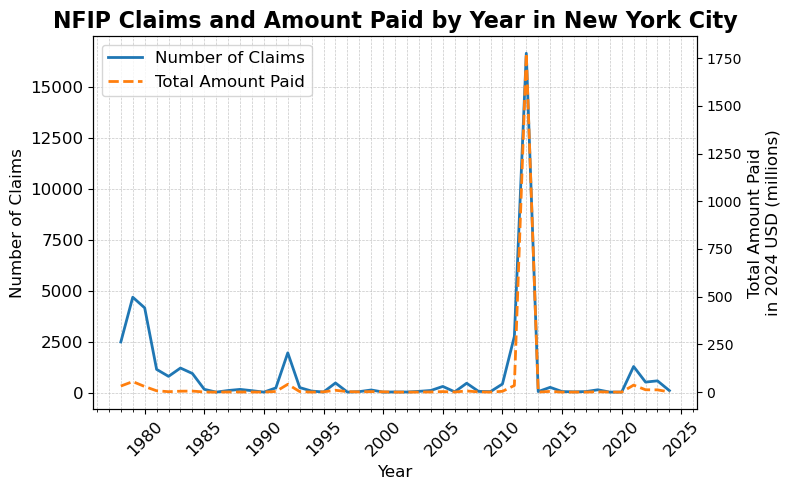

In [25]:
# create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# plot the number of claims (count_year) on the first axis with a thicker line
sns.lineplot(
    data=df,
    x='yearOfLoss',
    y='count',
    ax=ax1,
    color='C0',
    linewidth=2,  # thicker line for better visibility
    label='Number of Claims'  # add a label for the legend
)

# create a second y-axis for the amount paid (total_claim)
ax2 = ax1.twinx()

# plot the total claim amount (total_claim) on the second axis with a different line style
sns.lineplot(
    data=df,
    x='yearOfLoss',
    y='total_amount_paid2024M',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  # Dashed line for differentiation
    label='Total Amount Paid'
)

# set the title and labels with clear and concise text
ax1.set_title('NFIP Claims and Amount Paid by Year in New York City', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Claims', fontsize=12)
ax2.set_ylabel('Total Amount Paid\nin 2024 USD (millions)', fontsize=12)

# set the x-axis major and minor ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# combine the legends from both axes and put them in the upper left
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine the handles and labels from both axes
ax1.legend(handles + handles2, labels + labels2, loc='upper left', fontsize=12)
ax2.legend().set_visible(False)

# tight layout to adjust spacing
plt.tight_layout()
plt.savefig('figures/claims-paid-amount.png', bbox_inches='tight', dpi=210)

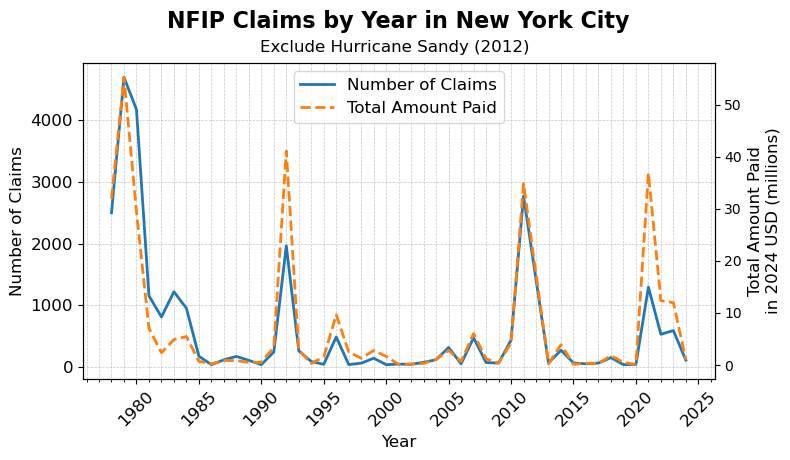

In [26]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=df.loc[df['yearOfLoss'] != 2012],
    x='yearOfLoss',
    y='count',
    ax=ax1,
    color='C0',
    linewidth=2,  
    label='Number of Claims',  
)

ax2 = ax1.twinx()

sns.lineplot(
    data=df.loc[df['yearOfLoss'] != 2012],
    x='yearOfLoss',
    y='total_amount_paid2024M',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  
    label='Total Amount Paid'
)

ax1.set_title('NFIP Claims by Year in New York City\n', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Claims', fontsize=12)
ax2.set_ylabel('Total Amount Paid\nin 2024 USD (millions)', fontsize=12)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax1.tick_params(axis='x', rotation=45)  
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)

ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12)
ax2.legend().set_visible(False)

plt.suptitle('Exclude Hurricane Sandy (2012)', y=.85)

plt.tight_layout()
plt.savefig('figures/claims-paid-amount-nosandy.png', bbox_inches='tight', dpi=210)

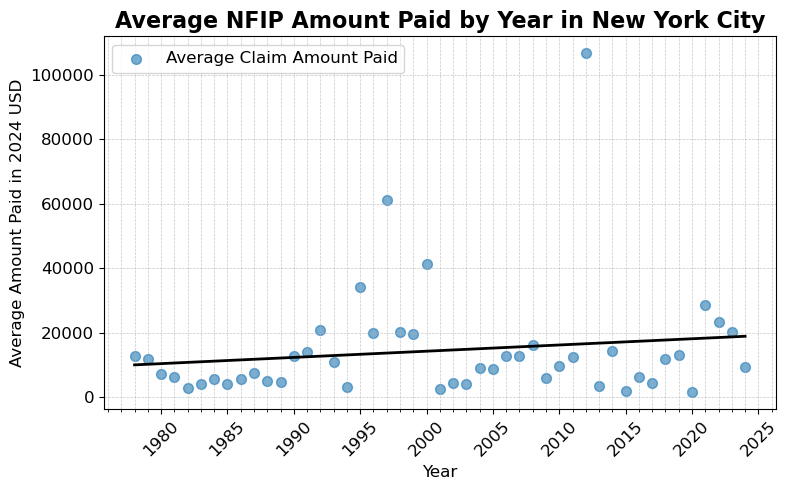

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

# plot the number of claims (average_claim) with a regression line
sns.regplot(
    data=df,
    x='yearOfLoss',
    y='average_amount_paid2024',
    ax=ax,
    color='C0',
    scatter_kws={'s': 50, 'alpha': 0.6},  # adjust scatter point size and transparency
    line_kws={'color': 'black', 'linewidth': 2},  # make the regression line black and thicker
    label='Average Claim Amount Paid', 
    ci=None  # remove confidence interval shading for cleaner presentation
)

ax.set_title('Average NFIP Amount Paid by Year in New York City', fontsize=16, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Amount Paid in 2024 USD', fontsize=12)

# set the x-axis major and minor ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# improve tick label formatting
ax.tick_params(axis='x', rotation=45)  # rotate x-ticks for better readability
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# add a grid with lighter lines and make sure the grid is only on the primary axis
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

# add the legend
ax.legend(loc='upper left', fontsize=12)

# tight layout to adjust spacing
plt.tight_layout()
plt.savefig('figures/average-paid-amount.png', bbox_inches='tight', dpi=210)

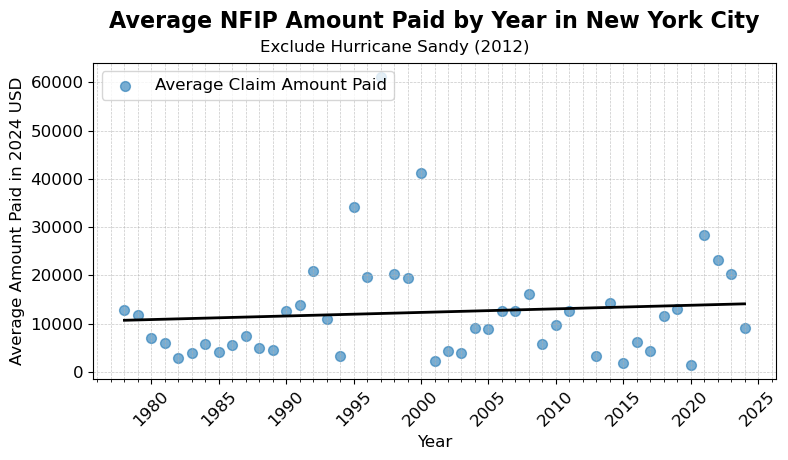

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.regplot(
    data=df.loc[df['yearOfLoss'] != 2012],
    x='yearOfLoss',
    y='average_amount_paid2024',
    ax=ax,
    color='C0',
    scatter_kws={'s': 50, 'alpha': 0.6},  
    line_kws={'color': 'black', 'linewidth': 2},  
    label='Average Claim Amount Paid',  
    ci=None  
)

ax.set_title('Average NFIP Amount Paid by Year in New York City\n', fontsize=16, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Average Amount Paid in 2024 USD', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend(loc='upper left', fontsize=12)

plt.suptitle('Exclude Hurricane Sandy (2012)', y=.85)

plt.tight_layout()
plt.savefig('figures/average-paid-amount-nosandy.png', bbox_inches='tight', dpi=210)

# Explore Policies Dataset

In [29]:
# sanity check, count policies
sql = """
    SELECT COUNT(*) AS count
    FROM policies
"""

con.sql(sql)

┌────────┐
│ count  │
│ int64  │
├────────┤
│ 548267 │
└────────┘

In [30]:
# sanity check, column data types
sql = """
    SELECT
        column_name,
        column_type
    FROM
        (DESCRIBE policies)
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────┬─────────────┐
│              column_name               │ column_type │
│                varchar                 │   varchar   │
├────────────────────────────────────────┼─────────────┤
│ agricultureStructureIndicator          │ BOOLEAN     │
│ baseFloodElevation                     │ DOUBLE      │
│ basementEnclosureCrawlspaceType        │ BIGINT      │
│ cancellationDateOfFloodPolicy          │ VARCHAR     │
│ condominiumCoverageTypeCode            │ VARCHAR     │
│ construction                           │ BOOLEAN     │
│ crsClassCode                           │ BIGINT      │
│ buildingDeductibleCode                 │ VARCHAR     │
│ contentsDeductibleCode                 │ VARCHAR     │
│ elevatedBuildingIndicator              │ BOOLEAN     │
│ elevationCertificateIndicator          │ VARCHAR     │
│ elevationDifference                    │ BIGINT      │
│ federalPolicyFee                       │ BIGINT      │
│ ratedFloodZone               

In [31]:
# sanity check, column null percentage
sql = """
    SELECT
        column_name,
        null_percentage
    FROM
        (SUMMARIZE FROM policies)
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
"""

con.sql(sql).show(max_rows=80)

┌────────────────────────────────────────┬─────────────────┐
│              column_name               │ null_percentage │
│                varchar                 │  decimal(9,2)   │
├────────────────────────────────────────┼─────────────────┤
│ crsClassCode                           │          100.00 │
│ cancellationDateOfFloodPolicy          │           97.35 │
│ cancellationVoidanceReasonCode         │           97.35 │
│ obstructionType                        │           87.74 │
│ lowestAdjacentGrade                    │           78.12 │
│ baseFloodElevation                     │           78.06 │
│ lowestFloorElevation                   │           78.06 │
│ elevationDifference                    │           77.99 │
│ propertyPurchaseDate                   │           67.29 │
│ elevationCertificateIndicator          │           64.63 │
│ enclosureTypeCode                      │           63.03 │
│ insuranceToValueCode                   │           53.61 │
│ premiumPaymentIndicato

In [32]:
# policies by year
sql = """
    SELECT
        strftime('%Y', CAST(policyEffectiveDate AS TIMESTAMP))::BIGINT AS policyEffectiveYear,
        SUM(policyCount)::BIGINT AS policyCount
    FROM
        policies 
    WHERE     
        policyEffectiveYear != '2025'
    GROUP BY
        policyEffectiveYear
    ORDER BY
        policyEffectiveYear      
"""

df = con.sql(sql).to_df()
print(df.shape)
df

(16, 2)


,policyEffectiveYear,policyCount
0,2009,37540
1,2010,38143
2,2011,39857
3,2012,41368
4,2013,56771
5,2014,56947
6,2015,57275
7,2016,57238
8,2017,55890
9,2018,54878


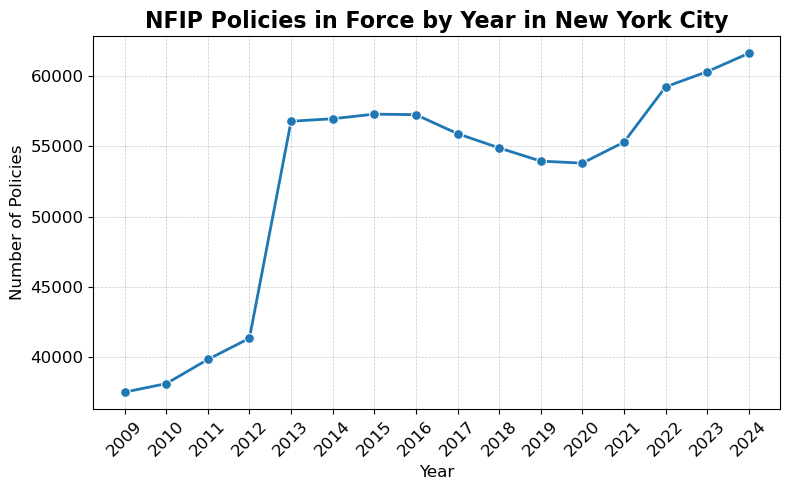

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=df,
    x='policyEffectiveYear',
    y='policyCount',
    ax=ax,
    color='C0',
    linewidth=2,  
    marker='o',  
    markersize=7,  
    linestyle='-',  
)

ax.set_title('NFIP Policies in Force by Year in New York City', fontsize=16, weight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Policies', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator())  

ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('figures/policies.png', bbox_inches='tight', dpi=210)

In [34]:
# policies dataset starts at 2009, filter claims to reflect same time interval
sql = """
    SELECT
        yearOfLoss,
        COUNT(*) AS count
    FROM
        claims
    WHERE
        yearOfLoss BETWEEN 2009 AND 2024
    GROUP BY
        yearOfLoss
    ORDER BY
        yearOfLoss      
"""

claims_df = con.sql(sql).to_df()
print(claims_df.shape)

claims_df.head()

(16, 2)


,yearOfLoss,count
0,2009,65
1,2010,437
2,2011,2771
3,2012,16656
4,2013,67


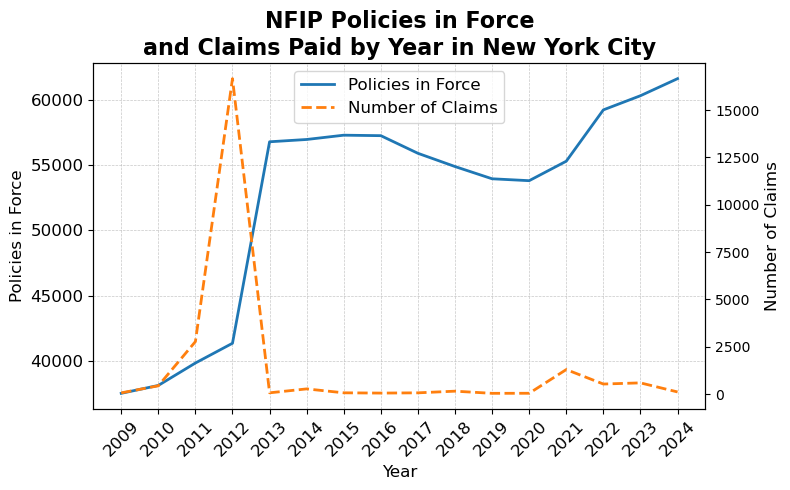

In [35]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=df,
    x='policyEffectiveYear',
    y='policyCount',
    ax=ax1,
    color='C0',
    linewidth=2, 
    label='Policies in Force',  
)

ax2 = ax1.twinx()

sns.lineplot(
    data=claims_df,
    x='yearOfLoss',
    y='count',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  
    label='Number of Claims'
)

ax1.set_title('NFIP Policies in Force\nand Claims Paid by Year in New York City', fontsize=16, weight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Policies in Force', fontsize=12)
ax2.set_ylabel('Number of Claims', fontsize=12)

ax1.xaxis.set_major_locator(ticker.MultipleLocator())

ax1.tick_params(axis='x', rotation=45) 
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12, facecolor='white')
ax2.legend().set_visible(False)

plt.tight_layout()
plt.savefig('figures/claims-policies.png', bbox_inches='tight', dpi=210)

In [36]:
# merge to one dataframe to calculate ratio claims / policies in force
merged_df = claims_df.merge(
    df,
    left_on='yearOfLoss',
    right_on='policyEffectiveYear'
)

# claims / policies in force
merged_df['claims_pif'] = merged_df['count'] / merged_df['policyCount']

merged_df.head()

,yearOfLoss,count,policyEffectiveYear,policyCount,claims_pif
0,2009,65,2009,37540,0.001731
1,2010,437,2010,38143,0.011457
2,2011,2771,2011,39857,0.069524
3,2012,16656,2012,41368,0.402630
4,2013,67,2013,56771,0.001180


In [37]:
# statistics of claims to policies in force ratio
merged_df['claims_pif'].describe()

count    16.000000
mean      0.033938
std       0.099805
min       0.000742
25%       0.001178
50%       0.002320
75%       0.010228
max       0.402630
Name: claims_pif, dtype: float64

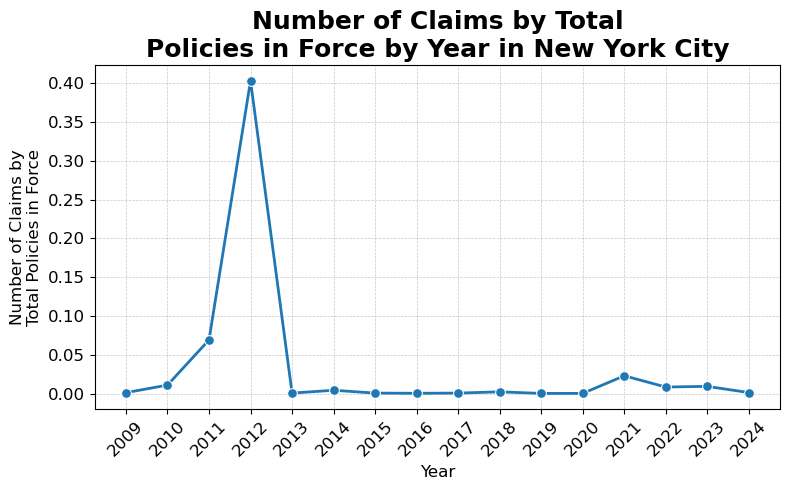

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=merged_df,
    x='policyEffectiveYear',
    y='claims_pif',
    ax=ax,
    color='C0',
    linewidth=2,  
    marker='o',  
    markersize=7,  
    linestyle='-',  
)

ax.set_title(
    'Number of Claims by Total\nPolicies in Force by Year in New York City', 
    fontsize=18, 
    weight='bold'
)
ax.set_xlabel('Year', fontsize=12)  
ax.set_ylabel('Number of Claims by\nTotal Policies in Force', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.tick_params(axis='x', rotation=45)  
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.savefig('figures/claims-policies-ratio.png', bbox_inches='tight', dpi=210)

# Claims by Month and Borough

NYC County FIPS codes:  
- The Bronx is Bronx County (FIPS 36005)  
- Brooklyn is Kings County (FIPS 36047)  
- Manhattan is New York County (FIPS 36061)  
- Queens is Queens County (FIPS 36081)  
- Staten Island is Richmond County (FIPS 36085)

In [39]:
sql = """
    SELECT
        CASE
            WHEN countyCode = 36005 THEN 'BX'
            WHEN countyCode = 36047 THEN 'BK'
            WHEN countyCode = 36061 THEN 'MN'
            WHEN countyCode = 36081 THEN 'QN'
            WHEN countyCode = 36085 THEN 'SI'
            END as county,
        strftime('%Y-%m', CAST(dateOfLoss AS TIMESTAMP)) AS year_month_loss,
        strftime('%m', CAST(dateOfLoss AS TIMESTAMP)) AS month_loss,
        COUNT(*) AS count_claim,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim
        ), 0)::BIGINT AS total_claim_paid
    FROM claims
    WHERE
        year_month_loss < '2025'
    GROUP BY
        countyCode, year_month_loss, month_loss
    ORDER BY
        year_month_loss ASC
"""

df = con.sql(sql).df()

print(df.shape)
df.head()

(1366, 5)


,county,year_month_loss,month_loss,count_claim,total_claim_paid
0,QN,1978-01,01,80,147667.0
1,MN,1978-01,01,14,53176.0
2,BK,1978-01,01,17,36652.0
3,BX,1978-01,01,5,5692.0
4,SI,1978-01,01,240,366224.0


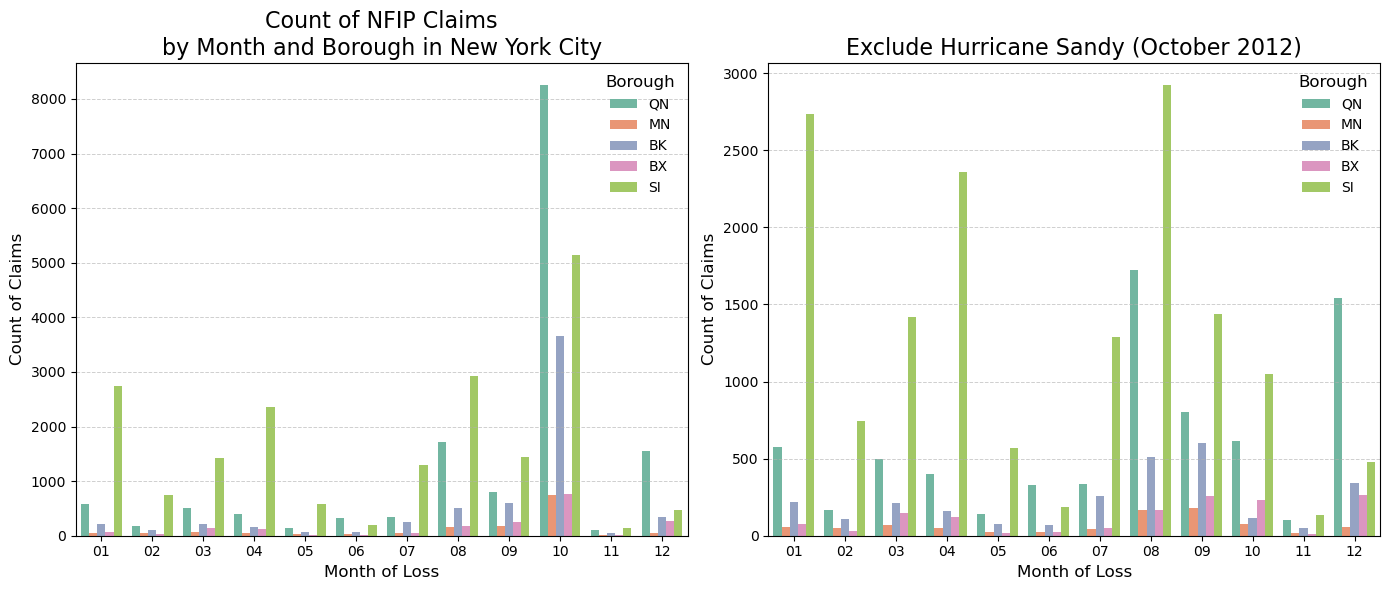

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

palette = sns.color_palette("Set2", n_colors=len(df['county'].unique()))

sns.barplot(
    data=df,
    x="month_loss",
    y="count_claim",
    estimator="sum",
    errorbar=None,
    hue='county',
    ax=axs[0],
    palette=palette
)

sns.barplot(
    data=df.loc[df['year_month_loss'] != '2012-10'],
    x="month_loss",
    y="count_claim",
    estimator="sum",
    errorbar=None,
    hue='county',
    ax=axs[1],
    palette=palette
)

axs[0].set_title('Count of NFIP Claims\nby Month and Borough in New York City', fontsize=16)
axs[1].set_title('Exclude Hurricane Sandy (October 2012)', fontsize=16)
axs[0].set_xlabel('Month of Loss', fontsize=12)
axs[1].set_xlabel('Month of Loss', fontsize=12)
axs[0].set_ylabel('Count of Claims', fontsize=12)
axs[1].set_ylabel('Count of Claims', fontsize=12)

axs[0].legend(title='Borough', fontsize=10, title_fontsize=12, frameon=False)
axs[1].legend(title='Borough', fontsize=10, title_fontsize=12, frameon=False)

axs[0].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
axs[1].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

fig.tight_layout()
plt.savefig('figures/claims-month.png', bbox_inches='tight', dpi=210)

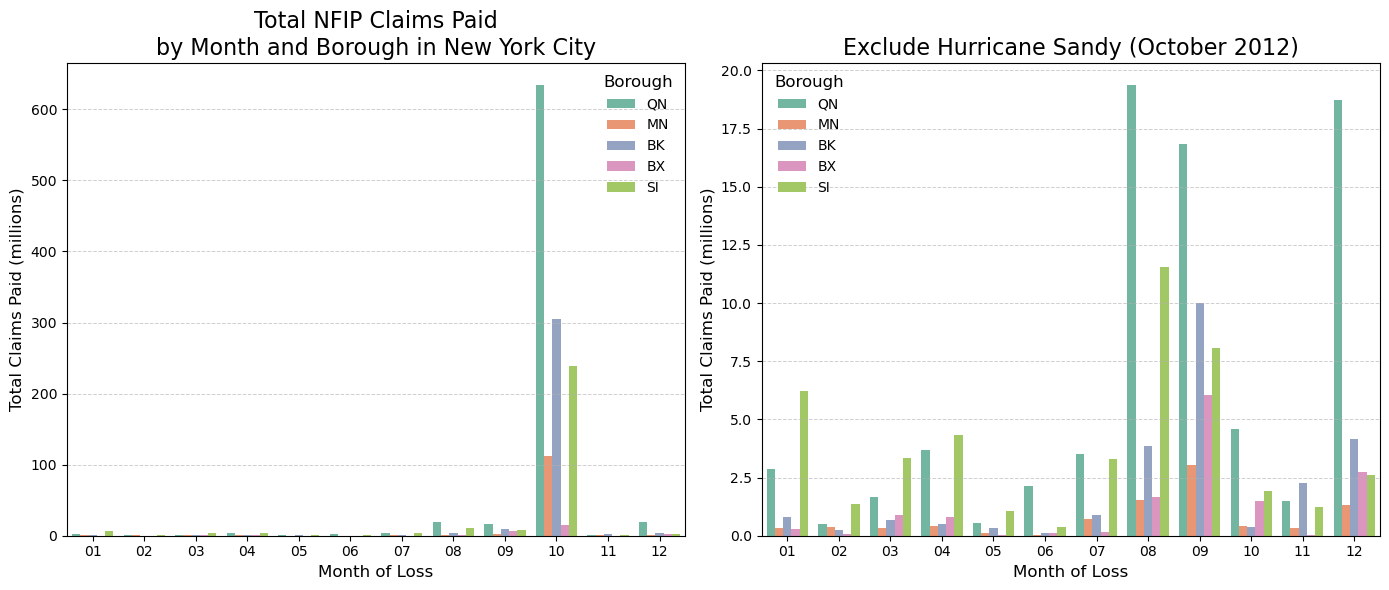

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

palette = sns.color_palette("Set2", n_colors=len(df['county'].unique()))

sns.barplot(
    data=df,
    x="month_loss",
    y=df["total_claim_paid"] / 1_000_000,
    estimator="sum",
    errorbar=None,
    hue='county',
    ax=axs[0],
    palette=palette 
)

sns.barplot(
    data=df.loc[df['year_month_loss'] != '2012-10'],
    x="month_loss",
    y=df["total_claim_paid"] / 1_000_000,
    estimator="sum",
    errorbar=None,
    hue='county',
    ax=axs[1],
    palette=palette
)

axs[0].set_title('Total NFIP Claims Paid\nby Month and Borough in New York City', fontsize=16)
axs[1].set_title('Exclude Hurricane Sandy (October 2012)', fontsize=16)
axs[0].set_xlabel('Month of Loss', fontsize=12)
axs[1].set_xlabel('Month of Loss', fontsize=12)
axs[0].set_ylabel('Total Claims Paid (millions)', fontsize=12)
axs[1].set_ylabel('Total Claims Paid (millions)', fontsize=12)

axs[0].legend(title='Borough', fontsize=10, title_fontsize=12, frameon=False)
axs[1].legend(title='Borough', fontsize=10, title_fontsize=12, frameon=False)

axs[0].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
axs[1].grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

fig.tight_layout()
plt.savefig('figures/claims-paid-month.png', bbox_inches='tight', dpi=210)

# NFIP Claims vs. 311 Street Flooding Complaints

In [42]:
sql = """
    SELECT
        strftime('%Y-%m', CAST(created_date AS TIMESTAMP)) AS year_month,
        COUNT(*) AS count_complaints
    FROM
        complaints
    WHERE
        year_month BETWEEN '2010-01' AND '2024-12'
    GROUP BY
        year_month
    ORDER BY
        year_month ASC
"""

complaints_df = con.sql(sql).df()
complaints_df['year_month'] = pd.to_datetime(complaints_df['year_month'])

print(complaints_df.shape)
complaints_df

(180, 2)


,year_month,count_complaints
0,2010-01-01,108
1,2010-02-01,187
2,2010-03-01,489
3,2010-04-01,149
4,2010-05-01,203
...,...,...
175,2024-08-01,389
176,2024-09-01,147
177,2024-10-01,86
178,2024-11-01,138


In [43]:
sql = """
    SELECT
        time_bucket('1 month', CAST(dateOfLoss AS TIMESTAMP)) AS year_month_loss,
        COUNT(*) AS count_claim
    FROM
        claims
    WHERE
        dateOfLoss BETWEEN '2010-01-01' AND '2024-12-31'
    GROUP BY
        year_month_loss
    ORDER BY
        year_month_loss
"""

claims_df = con.sql(sql).df()
claims_df['year_month_loss'] = pd.to_datetime(claims_df['year_month_loss'])

print(claims_df.shape)
claims_df

(163, 2)


,year_month_loss,count_claim
0,2010-01-01,4
1,2010-02-01,11
2,2010-03-01,370
3,2010-04-01,10
4,2010-05-01,3
...,...,...
158,2024-06-01,2
159,2024-07-01,3
160,2024-08-01,13
161,2024-09-01,2


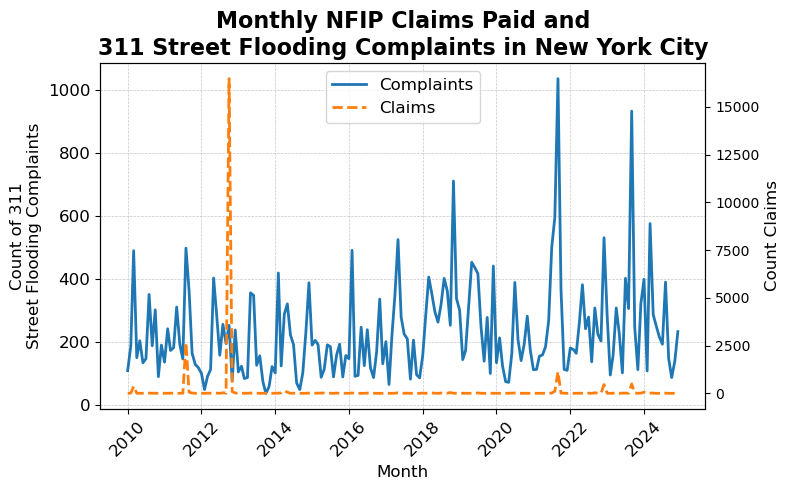

In [44]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=complaints_df,
    x='year_month',
    y='count_complaints',
    ax=ax1,
    color='C0',
    linewidth=2, 
    label='Complaints',  
)

ax2 = ax1.twinx()

sns.lineplot(
    data=claims_df,
    x='year_month_loss',
    y='count_claim',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',  
    label='Claims'
)

ax1.set_title('Monthly NFIP Claims Paid and\n311 Street Flooding Complaints in New York City', fontsize=16, weight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Count of 311\nStreet Flooding Complaints', fontsize=12)
ax2.set_ylabel('Count Claims', fontsize=12)

ax1.tick_params(axis='x', rotation=45)  # Rotate x-ticks for better readability
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12, facecolor='white')
ax2.legend().set_visible(False)

plt.tight_layout()
plt.savefig('figures/claims-311complaints.png', bbox_inches='tight', dpi=210)

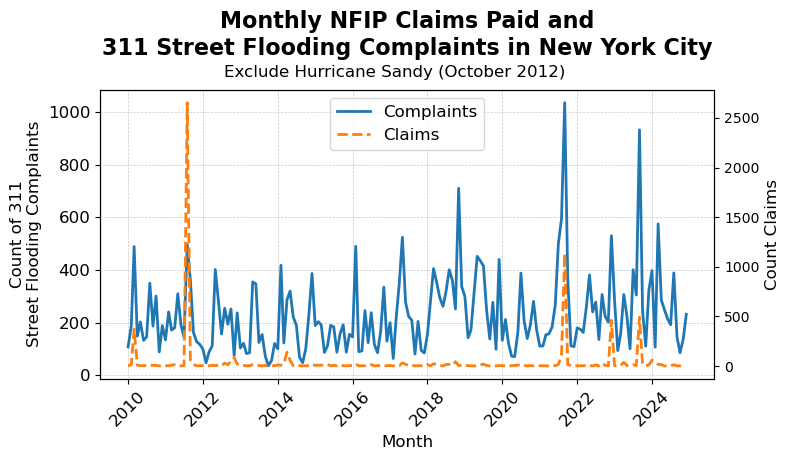

In [45]:
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(
    data=complaints_df,
    x='year_month',
    y='count_complaints',
    ax=ax1,
    color='C0',
    linewidth=2, 
    label='Complaints',  
)

ax2 = ax1.twinx()

sns.lineplot(
    data=claims_df.loc[claims_df['year_month_loss'] != '2012-10-01'],
    x='year_month_loss',
    y='count_claim',
    ax=ax2,
    color='C1',
    linewidth=2,  
    linestyle='--',
    label='Claims'
)

ax1.set_title('Monthly NFIP Claims Paid and\n311 Street Flooding Complaints in New York City\n', fontsize=16, weight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Count of 311\nStreet Flooding Complaints', fontsize=12)
ax2.set_ylabel('Count Claims', fontsize=12)

ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles + handles2, labels + labels2, loc='upper center', fontsize=12, facecolor='white')
ax2.legend().set_visible(False)

plt.suptitle('Exclude Hurricane Sandy (October 2012)', y=.80)

plt.tight_layout()
plt.savefig('figures/claims-311complaints-nosandy.png', bbox_inches='tight', dpi=210)